# Обучение с учителем: качество модели

Ссылка на GitHub: https://github.com/Nvazhenina/Supervised_learning

**Заказчик** этого исследования — интернет-магазин «В один клик».<br><br>
**Цель проекта:**
- построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца. 
- выделить сегменты покупателей и разработать для них персонализированные предложения. 

**Описание данных:**<br>
данные содержат информацию: коммуникации с клиентом, продуктовое и финансовое поведение, поведение на сайте.
Данные содержатся в 4 csv-файлах: market_file, market_money, market_time, money.

**План работ:**<br>
- загрузить данные
- предобработать данные: преобразовать типы, заполнить пропуски, обработать дубликаты.
- исследовать общую информацию, отобрать клиентов с покупательской активностью не менее трёх месяцев.
- объединить данные и визуализировать информацию.
- провести корреляционный анализ.
- выбрать лучшую модель для предсказания снижения покупательной активности.
- проанализировать важность признаков в выбранной модели.
- выделить сегмент покупателей и подготовить персональные предложения.

In [1]:
!pip install phik -q
!pip install shap -q

In [2]:
#импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
import seaborn as sns
import phik
from sklearn.model_selection import train_test_split

# загружаем класс pipeline
from sklearn.pipeline import Pipeline

# загружаем классы для подготовки данных
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.compose import ColumnTransformer

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# загружаем функцию для работы с метриками
from sklearn.metrics import roc_auc_score

# импортируем класс RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

# загружаем нужные модели
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

import shap

from warnings import simplefilter

In [3]:
pd.set_option('chained_assignment', None)

# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

## Загрузка данных

In [5]:
#market_file = pd.read_csv('/datasets/market_file.csv').to_csv('market_file')
#market_money = pd.read_csv('/datasets/market_money.csv').to_csv('market_money')
#market_time = pd.read_csv('/datasets/market_time.csv').to_csv('market_time')
#money = pd.read_csv('/datasets/money.csv').to_csv('money')

In [4]:
market_file = pd.read_csv('/datasets/market_file.csv', sep = ',')
market_money = pd.read_csv('/datasets/market_money.csv', sep = ',')
market_time = pd.read_csv('/datasets/market_time.csv', sep = ',')
money = pd.read_csv('/datasets/money.csv', sep = ';', decimal = ',')

In [5]:
market_file.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [6]:
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

In [7]:
market_money.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [8]:
market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [9]:
market_time.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [10]:
market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [11]:
money.head()

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


In [12]:
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


Загрузили данные из четырех источников.<br>
В таблице **market_file** 1300 строк, пропуски отсутствуют. Типы данных соответствуют. Таблица содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении. <br>
В таблице **market_money** 3900 строк, пропусков нет, типы данных соответствуют. Она хранит данные о выручке, которую получает магазин с покупателя.<br>
В таблице **market_time** 2600 строк, пропусков нет, типы данных соответствуют. Таблица хранит данные о времени (в минутах), которое покупатель провёл на сайте в течение периода.<br>
В таблице **money** 1300 строк, пропусков нет, типы данных соответствуют. Таблица хранит данные о среднемесячной прибыли покупателя за последние 3 месяца. <br>
<br>
Данные в таблицах соответсвуют описанию.

##  Предобработка данных

### Исследование таблицы market_file

In [13]:
#Проверка на пропуски в данных
market_file.isna().sum()

id                                     0
Покупательская активность              0
Тип сервиса                            0
Разрешить сообщать                     0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность                           0
Акционные_покупки                      0
Популярная_категория                   0
Средний_просмотр_категорий_за_визит    0
Неоплаченные_продукты_штук_квартал     0
Ошибка_сервиса                         0
Страниц_за_визит                       0
dtype: int64

In [14]:
# проверка на явные дубликаты
market_file.duplicated().sum()

0

Пропусков и дубликатов в таблице market_file нет.<br>
Проверим неявные дубликаты.

In [15]:
market_file['id'].duplicated().sum()

0

In [16]:
market_file['Покупательская активность'].value_counts()

Прежний уровень    802
Снизилась          498
Name: Покупательская активность, dtype: int64

In [17]:
market_file['Тип сервиса'].value_counts()

стандарт     914
премиум      376
стандартт     10
Name: Тип сервиса, dtype: int64

В поле Тип сервиса есть неявный дубликат "стандартт". Переименуем его.

In [18]:
market_file['Тип сервиса'] = market_file['Тип сервиса'].replace('стандартт','стандарт')

In [19]:
market_file['Тип сервиса'].value_counts()

стандарт    924
премиум     376
Name: Тип сервиса, dtype: int64

In [20]:
market_file['Разрешить сообщать'].value_counts()

да     962
нет    338
Name: Разрешить сообщать, dtype: int64

In [21]:
market_file['Популярная_категория'].value_counts()

Товары для детей                        330
Домашний текстиль                       251
Косметика и аксесуары                   223
Техника для красоты и здоровья          184
Мелкая бытовая техника и электроника    174
Кухонная посуда                         138
Name: Популярная_категория, dtype: int64

В других столбцах неявных дубликатов обнаружено не было.

### Исследование таблицы market_money

In [22]:
#Проверка на пропуски в данных
market_money.isna().sum()

id         0
Период     0
Выручка    0
dtype: int64

In [23]:
# проверка на явные дубликаты
market_money.duplicated().sum()

0

Пропусков и дубликатов в таблице market_money нет.<br>
Проверим неявные дубликаты.

In [24]:
market_money['Период'].value_counts()

препредыдущий_месяц    1300
текущий_месяц          1300
предыдущий_месяц       1300
Name: Период, dtype: int64

Неявных дубликатов не обнаружено.

### Исследование таблицы market_time

In [25]:
#Проверка на пропуски в данных
market_time.isna().sum()

id        0
Период    0
минут     0
dtype: int64

In [26]:
# проверка на явные дубликаты
market_time.duplicated().sum()

0

In [27]:
market_time['Период'].value_counts()

предыдцщий_месяц    1300
текущий_месяц       1300
Name: Период, dtype: int64

Исправим значение "предыдцщий_месяц".

In [28]:
market_time['Период'] = market_time['Период'].replace('предыдцщий_месяц', 'предыдущий_месяц')

In [29]:
market_time['Период'].value_counts()

текущий_месяц       1300
предыдущий_месяц    1300
Name: Период, dtype: int64

Неявных дубликатов не обнаружено. Сделали значения столбца Период единообразно с таблицей market_money.

### Исследование таблицы money

In [30]:
#Проверка на пропуски в данных
money.isna().sum()

id         0
Прибыль    0
dtype: int64

In [31]:
# проверка на явные дубликаты
money.duplicated().sum()

0

Дубликатов не обнаружено.

## Исследовательский анализ данных

### Анализ количественных признаков

In [32]:
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

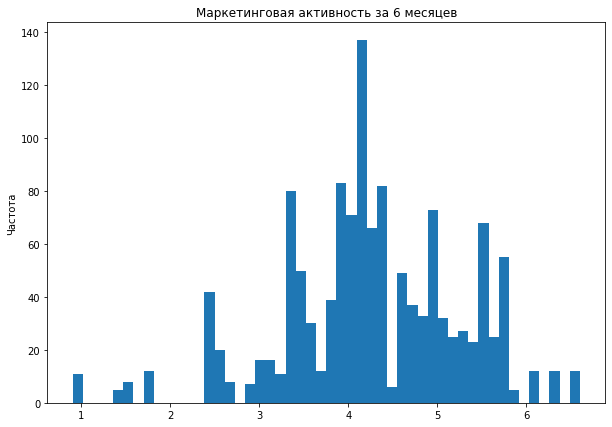

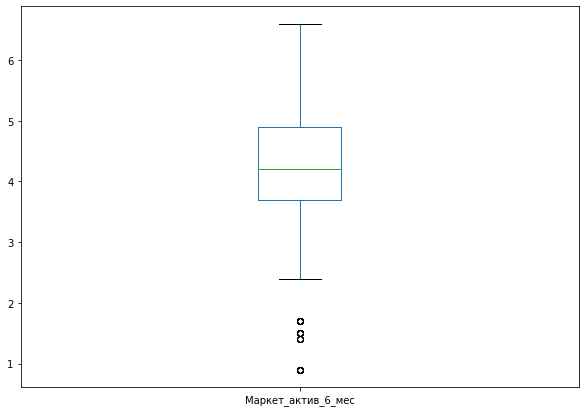

In [33]:
market_file.plot(y='Маркет_актив_6_мес',title='Маркетинговая активность за 6 месяцев', kind='hist' ,bins=50, figsize = (10,7), legend = False)
plt.ylabel("Частота");
market_file.plot(y='Маркет_актив_6_мес', kind='box' , figsize = (10,7), legend = False);

In [34]:
market_file.describe()

,id,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,215997.500000,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,375.421985,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,215348.000000,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,215672.750000,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,215997.500000,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,216322.250000,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,216647.000000,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000


Распределение признака Маркет_актив_6_мес не очень похоже на нормальное. Есть некоторые всплески.<br>
В среднем маркетинговая активность за 6 месяцев 4,25.<br>
Разброс довольно большой, но в основном активность составляет от 3,7 до 4,9 кг.

In [35]:
market_file['Маркет_актив_тек_мес'].value_counts()

4    669
5    323
3    308
Name: Маркет_актив_тек_мес, dtype: int64

Маркет_актив_тек_мес принимает всего 3 значения, т.е. это категориальный ранговый признак

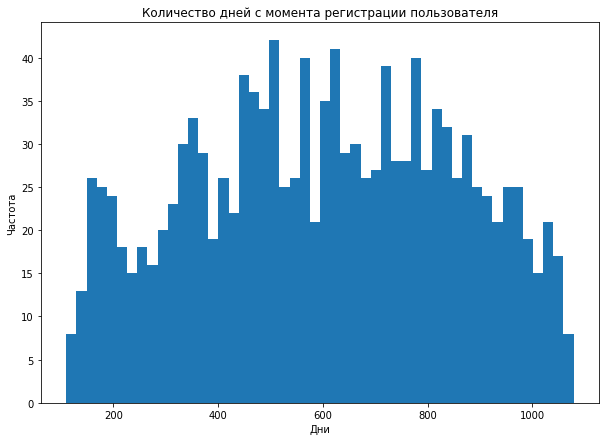

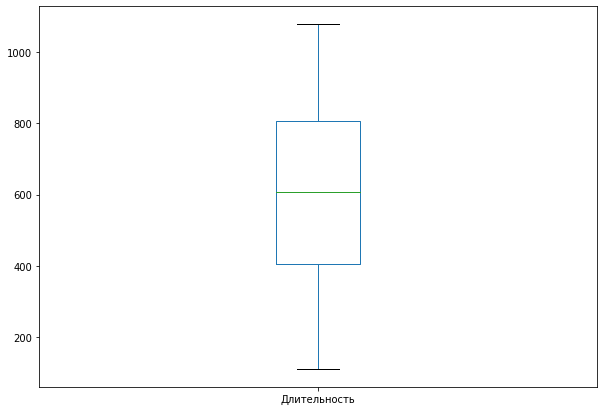

In [36]:
market_file.plot(y='Длительность',title='Количество дней с момента регистрации пользователя', kind='hist' ,bins=50, figsize = (10,7), legend = False)
plt.xlabel("Дни");
plt.ylabel("Частота");
market_file.plot(y='Длительность', kind='box' , figsize = (10,7), legend = False);

Распределение признака Длительность не очень похоже на нормальное.<br>
В среднем Длительность составляет 602 дня.<br>
Разброс довольно большой, но в основном принимает значения от 406 до 806 кг.

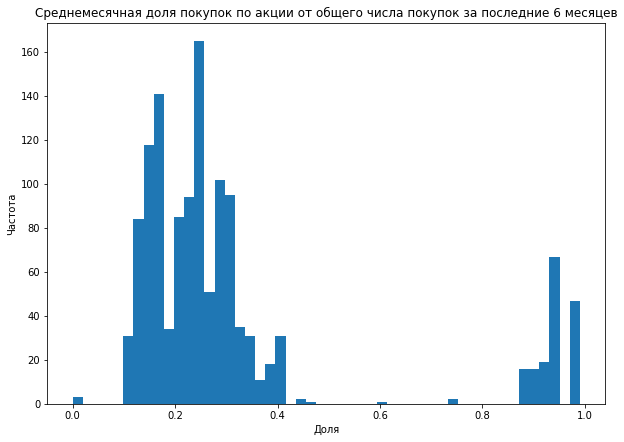

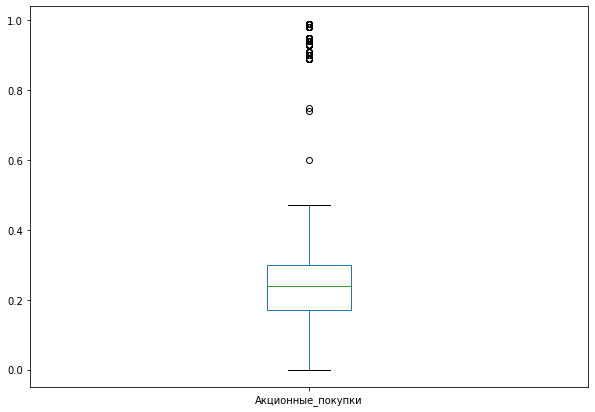

In [37]:
market_file.plot(y='Акционные_покупки',title='Среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев', kind='hist' ,bins=50, figsize = (10,7), legend = False)
plt.xlabel("Доля");
plt.ylabel("Частота");
market_file.plot(y='Акционные_покупки', kind='box' , figsize = (10,7), legend = False);

В среднем Акционные покупки составляют 0,32. При этом медиана меньше и составляет 0,24.<br>
Разброс довольно большой, но в основном принимает значения от 0,17 до 0,3 кг. У некоторых покупателей есть значения значительно больше: 0,99. Т.е. они покупают только акционные товары.

Остальные показатели в таблице market_file можно отнести к категориальным.

In [38]:
market_money.describe()

,id,Выручка
count,3900.000000,3900.000000
mean,215997.500000,5025.696051
std,375.325686,1777.704104
min,215348.000000,0.000000
25%,215672.750000,4590.150000
50%,215997.500000,4957.500000
75%,216322.250000,5363.000000
max,216647.000000,106862.200000


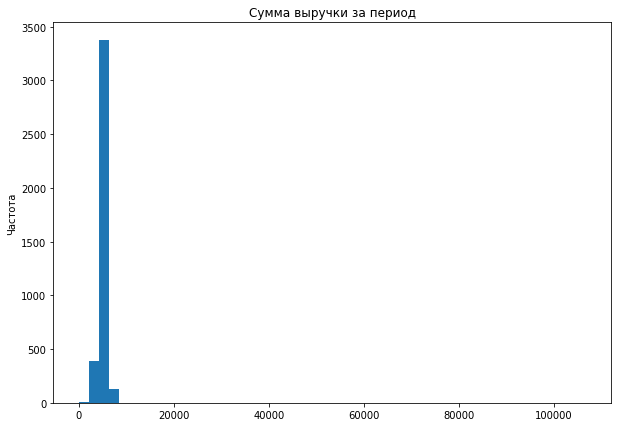

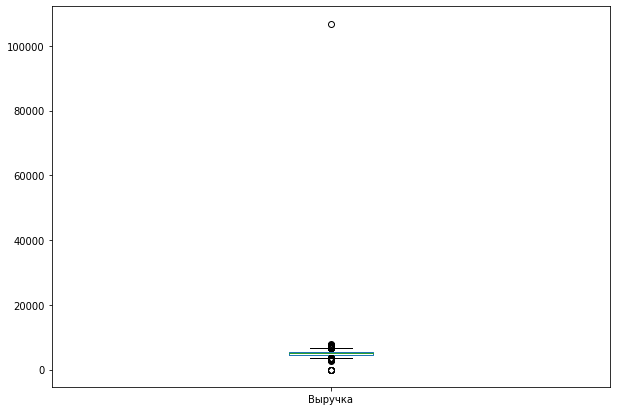

In [39]:
market_money.plot(y='Выручка',title='Сумма выручки за период', kind='hist' ,bins=50, figsize = (10,7), legend = False)
plt.ylabel("Частота");
market_money.plot(y='Выручка', kind='box' , figsize = (10,7), legend = False);

На данном графике есть аномальное значение. Изучим его подробнее.

In [40]:
market_money.query('Выручка > 100000')

,id,Период,Выручка
98,215380,текущий_месяц,106862.2


Посмотрим на прибыль данного клиента.

In [41]:
money.query('id == 215380')

,id,Прибыль
32,215380,3.88


In [42]:
money.describe()

,id,Прибыль
count,1300.000000,1300.000000
mean,215997.500000,3.996631
std,375.421985,1.013722
min,215348.000000,0.860000
25%,215672.750000,3.300000
50%,215997.500000,4.045000
75%,216322.250000,4.670000
max,216647.000000,7.430000


Прибыль по нему даже меньше среднего значения, скорее всего это ошибка.<br>
Удалим это значение, но в целом лучше запросить более подробную информацию о покупателе.

In [43]:
market_file.query('id == 215380')

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
32,215380,Снизилась,премиум,нет,1.7,4,637,0.94,Техника для красоты и здоровья,3,2,4,7


In [44]:
market_money = market_money.query('id != 215380')

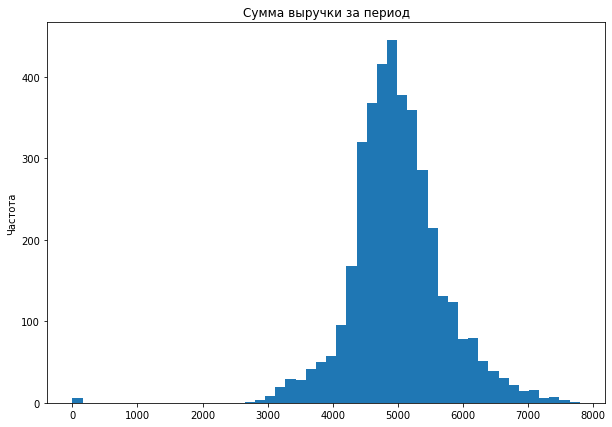

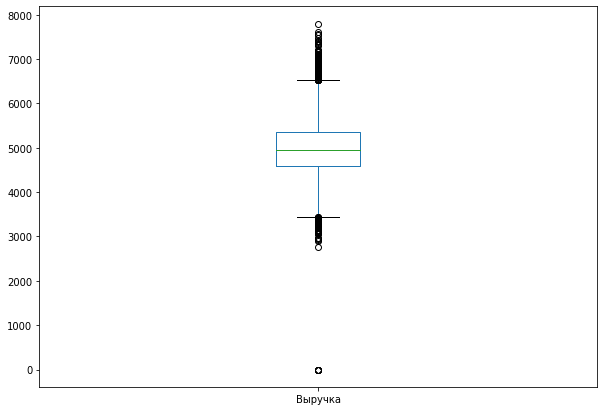

In [45]:
market_money.plot(y='Выручка',title='Сумма выручки за период', kind='hist' ,bins=50, figsize = (10,7), legend = False)
plt.ylabel("Частота");
market_money.plot(y='Выручка', kind='box' , figsize = (10,7), legend = False);

Распределение стало близко к нормальному.<br>
В среднем Выручка составляет 4999.<br>
Разброс довольно большой, но в основном принимает значения от 4590 до 5363. 

In [46]:
market_money.describe()

,id,Выручка
count,3897.000000,3897.000000
mean,215997.975366,4999.287760
std,375.078662,706.970089
min,215348.000000,0.000000
25%,215673.000000,4590.000000
50%,215998.000000,4956.000000
75%,216323.000000,5363.000000
max,216647.000000,7799.400000


In [47]:
market_time.describe()

,id,минут
count,2600.000000,2600.000000
mean,215997.500000,13.336154
std,375.349754,4.080198
min,215348.000000,4.000000
25%,215672.750000,10.000000
50%,215997.500000,13.000000
75%,216322.250000,16.000000
max,216647.000000,23.000000


In [48]:
money.describe()

,id,Прибыль
count,1300.000000,1300.000000
mean,215997.500000,3.996631
std,375.421985,1.013722
min,215348.000000,0.860000
25%,215672.750000,3.300000
50%,215997.500000,4.045000
75%,216322.250000,4.670000
max,216647.000000,7.430000


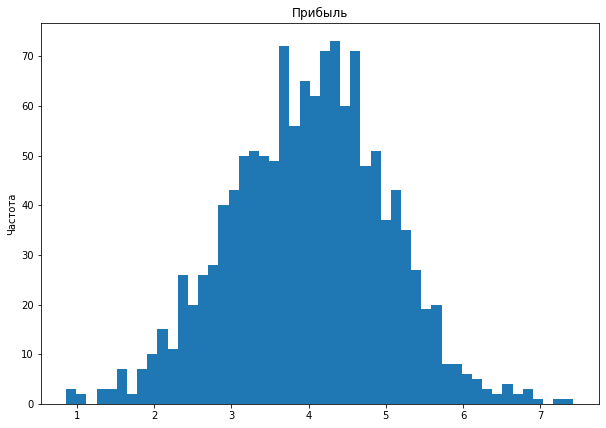

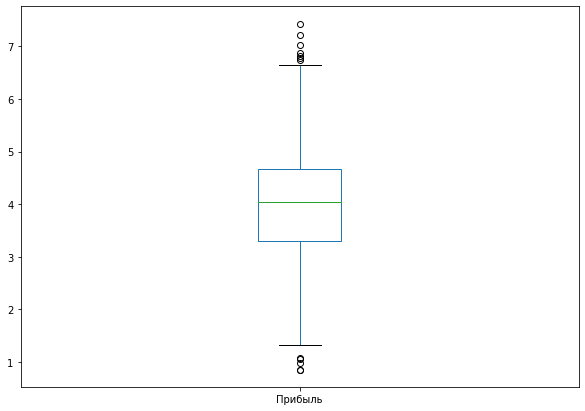

In [49]:
money.plot(y='Прибыль',title='Прибыль', kind='hist' ,bins=50, figsize = (10,7), legend = False)
plt.ylabel("Частота");
money.plot(y='Прибыль', kind='box' , figsize = (10,7), legend = False);

Распределение близко к нормальному.<br>
В среднем Прибыль составляет 4.<br>
В основном принимает значения от 3,3 до 4,7. 

Также заметим, что у количественных признаков разный масштаб, поэтому необходимо будет провести **масштабирование**.

### Анализ категориальных переменных

In [50]:
market_file.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


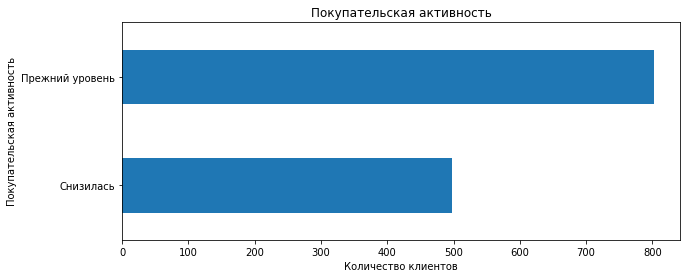

In [51]:
market_file.pivot_table(index = 'Покупательская активность', aggfunc = 'count')['id'].sort_values().plot(y='Покупательская активность',title='Покупательская активность', kind='barh' , figsize = (10,4), legend = False)
plt.ylabel("Покупательская активность");
plt.xlabel("Количество клиентов");

У большинства клиентов покупательная способность осталась на прежнем уровне. Но довольно много клиентов, у которых активность снизилась. С ними и нужно работать.

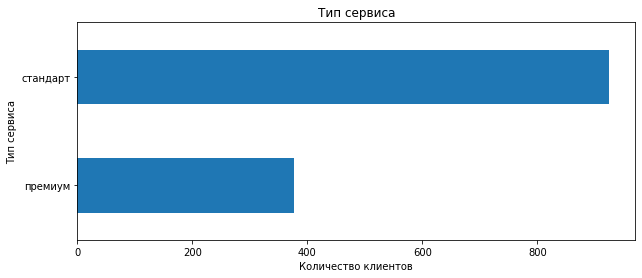

In [52]:
market_file.pivot_table(index = 'Тип сервиса', aggfunc = 'count')['id'].sort_values().plot(y='Тип сервиса',title='Тип сервиса', kind='barh' , figsize = (10,4), legend = False)
plt.ylabel("Тип сервиса");
plt.xlabel("Количество клиентов");

Около трети клиентов с уровнем сервиса премиум.

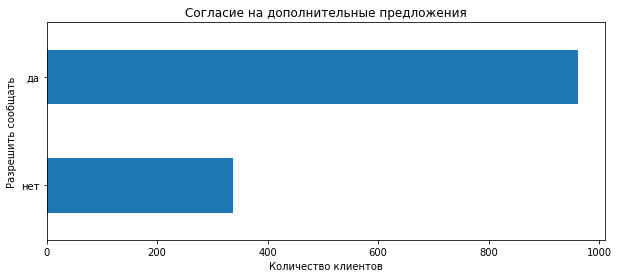

In [53]:
market_file.pivot_table(index = 'Разрешить сообщать', aggfunc = 'count')['id'].sort_values().plot(y='Разрешить сообщать',title='Согласие на дополнительные предложения', kind='barh' , figsize = (10,4), legend = False)
plt.ylabel("Разрешить сообщать");
plt.xlabel("Количество клиентов");

Лишь небольшая доля клиентов не желает, чтобы им рассылали дополнительные предложения.

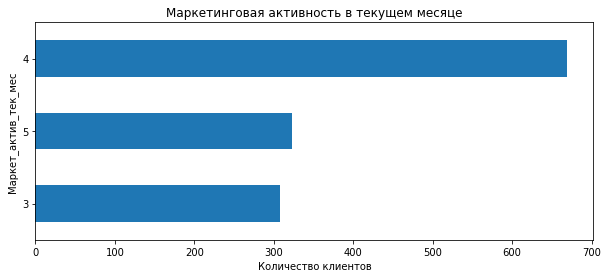

In [54]:
market_file.pivot_table(index = 'Маркет_актив_тек_мес', aggfunc = 'count')['id'].sort_values().plot(y='Маркет_актив_тек_мес',title='Маркетинговая активность в текущем месяце', kind='barh' , figsize = (10,4), legend = False)
plt.ylabel("Маркет_актив_тек_мес");
plt.xlabel("Количество клиентов");

Большинство клиентов со средней маркетинговой активностью 4.

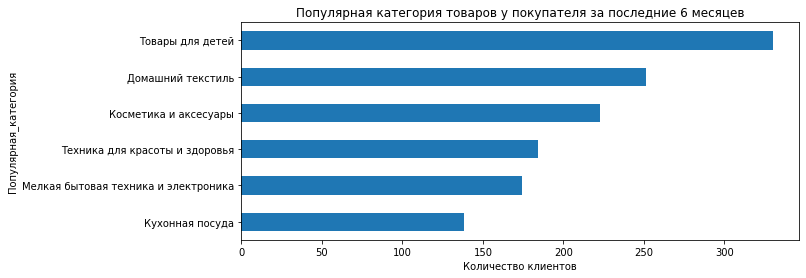

In [55]:
market_file.pivot_table(index = 'Популярная_категория', aggfunc = 'count')['id'].sort_values().plot(y='Популярная_категория',title='Популярная категория товаров у покупателя за последние 6 месяцев', kind='barh' , figsize = (10,4), legend = False)
plt.ylabel("Популярная_категория");
plt.xlabel("Количество клиентов");

Самой популярной категорией является Товары для детей.

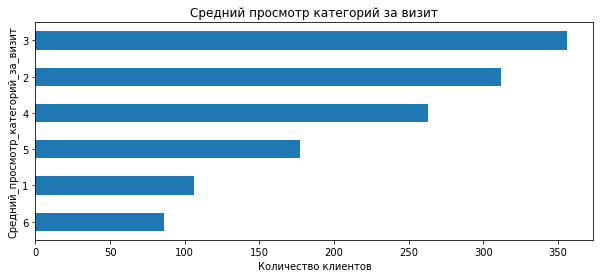

In [56]:
market_file.pivot_table(index = 'Средний_просмотр_категорий_за_визит', aggfunc = 'count')['id'].sort_values().plot(y='Средний_просмотр_категорий_за_визит',title='Средний просмотр категорий за визит', kind='barh' , figsize = (10,4), legend = False)
plt.ylabel("Средний_просмотр_категорий_за_визит");
plt.xlabel("Количество клиентов");

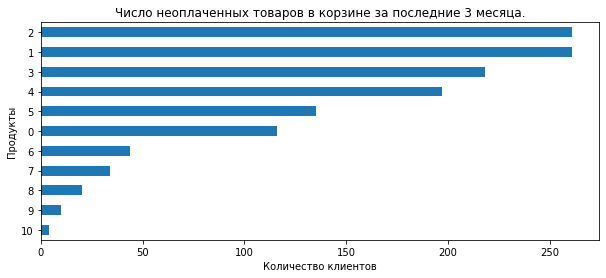

In [57]:
market_file.pivot_table(index = 'Неоплаченные_продукты_штук_квартал', aggfunc = 'count')['id'].sort_values().plot(y='Неоплаченные_продукты_штук_квартал',title='Число неоплаченных товаров в корзине за последние 3 месяца.', kind='barh' , figsize = (10,4), legend = False)
plt.ylabel("Продукты");
plt.xlabel("Количество клиентов");

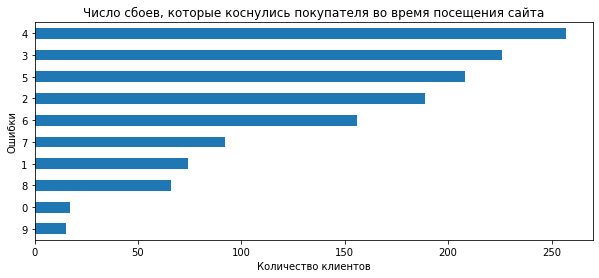

In [58]:
market_file.pivot_table(index = 'Ошибка_сервиса', aggfunc = 'count')['id'].sort_values().plot(y='Ошибка_сервиса',title='Число сбоев, которые коснулись покупателя во время посещения сайта', kind='barh' , figsize = (10,4), legend = False)
plt.ylabel("Ошибки");
plt.xlabel("Количество клиентов");

Очень малая доля клиентов, которых не коснулись сбои.

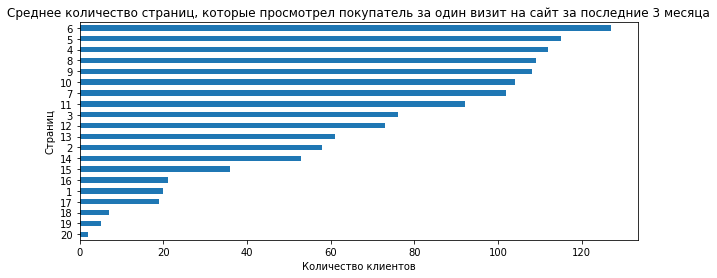

In [59]:
market_file.pivot_table(index = 'Страниц_за_визит', aggfunc = 'count')['id'].sort_values().plot(y='Страниц_за_визит',title='Среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца', kind='barh' , figsize = (10,4), legend = False)
plt.ylabel("Страниц");
plt.xlabel("Количество клиентов");

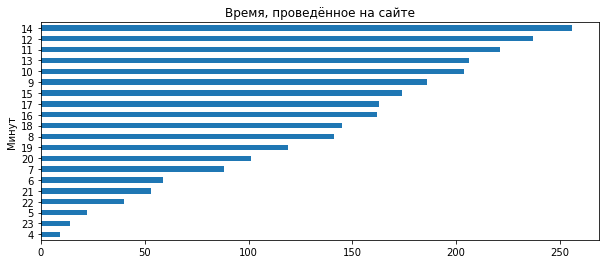

In [60]:
market_time.pivot_table(index = 'минут', aggfunc = 'count')['id'].sort_values().plot(y='минут',title='Время, проведённое на сайте', kind='barh' , figsize = (10,4), legend = False)
plt.ylabel("Минут");

### Отбор клиентов с покупательной активностью не менее 3 месяцев

In [61]:
market_money.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


Преобразуем таблицу к виду, где каждому периоду будет соответствовать отдельный столбец.

In [62]:
market_money_pivot = market_money.pivot_table(index='id', columns = 'Период', aggfunc = 'sum')

In [63]:
#переименуем столбцы
market_money_pivot.columns = ['Выручка_пред','Выручка_предпред','Выручка_тек']

Исключим тех клиентов, у кого в одном из последних трех месяцев не было покупок.

In [64]:
market_money_pivot = market_money_pivot.query('Выручка_пред*Выручка_предпред*Выручка_тек!=0')

In [65]:
market_money_pivot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 215349 to 216647
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Выручка_пред      1296 non-null   float64
 1   Выручка_предпред  1296 non-null   float64
 2   Выручка_тек       1296 non-null   float64
dtypes: float64(3)
memory usage: 40.5 KB


Таких клиентов оказалось 3.

**Проанализировали признаки**:
- целевой признак Покупательная активность: У большинства клиентов покупательная способность осталась на прежнем уровне. Но довольно много клиентов, у которых активность снизилась. С ними и нужно работать - рассылать персонализированные предложения.
- количественные признаки: аномальное значение было замечено только по признаку Выручка. Это значение проверили и удалили.
- категориальные признаки: проанлизировали и просмотрели возможные значения.<br>

Необходимо масштабировать количественные признаки и закодировать категориальные для использования их в модели. А также проследить, нет ли взаимосвязи между признаками и наблюдается ли линейная взаимосвязь с целевым признаком.

## Объединение таблиц

Сначала приведем таблицу market_time к виду, где каждому периоду будет соответствовать отдельный столбец.

In [66]:
market_time.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдущий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдущий_месяц,12
4,215350,текущий_месяц,13


In [67]:
market_time_pivot = market_time.pivot_table(index='id', columns = 'Период', aggfunc = 'sum')

In [68]:
market_time_pivot.head()

минут              
Период предыдущий_месяц текущий_месяц
id                                   
215348               13            14
215349               12            10
215350                8            13
215351               11            13
215352                8            11

In [69]:
#переименуем столбцы
market_time_pivot.columns = ['Минут_пред','Минут_тек']

In [70]:
market_time_pivot.head()

,Минут_пред,Минут_тек
id,,
215348,13,14
215349,12,10
215350,8,13
215351,11,13
215352,8,11


In [71]:
#объединим таблицы
data_all = market_money_pivot.merge(market_file, on = 'id')

In [72]:
data_all = data_all.merge(market_time_pivot, on = 'id')

In [73]:
data_all.head()

,id,Выручка_пред,Выручка_предпред,Выручка_тек,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Минут_пред,Минут_тек
0,215349,5216.0,4472.0,4971.6,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,12,10
1,215350,5457.5,4826.0,5058.4,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,8,13
2,215351,6158.0,4793.0,6610.4,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,11,13
3,215352,5807.5,4594.0,5872.5,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,8,11
4,215353,4738.5,5124.0,5388.5,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,10,10


Проверим, что объединение прошло корректно.

In [74]:
data_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 0 to 1295
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1296 non-null   int64  
 1   Выручка_пред                         1296 non-null   float64
 2   Выручка_предпред                     1296 non-null   float64
 3   Выручка_тек                          1296 non-null   float64
 4   Покупательская активность            1296 non-null   object 
 5   Тип сервиса                          1296 non-null   object 
 6   Разрешить сообщать                   1296 non-null   object 
 7   Маркет_актив_6_мес                   1296 non-null   float64
 8   Маркет_актив_тек_мес                 1296 non-null   int64  
 9   Длительность                         1296 non-null   int64  
 10  Акционные_покупки                    1296 non-null   float64
 11  Популярная_категория          

Объединение прошло успешно. Количество строк осталось прежним 1296, новые столбцы добавились.

## Корреляционный анализ

In [75]:
data_all.phik_matrix(interval_cols = ['id', 'Выручка_пред', 'Выручка_предпред', 'Выручка_тек', 'Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки', 'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 'Страниц_за_визит', 'Минут_пред', 'Минут_тек'])

,id,Выручка_пред,Выручка_предпред,Выручка_тек,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Минут_пред,Минут_тек
id,1.000000,0.238373,0.421755,0.173750,0.984597,0.116473,0.019783,0.466290,0.000000,0.050714,0.413956,0.171846,0.353945,0.418111,0.204583,0.608831,0.564878,0.473579
Выручка_пред,0.238373,1.000000,0.358313,0.836281,0.224638,0.000000,0.080842,0.155476,0.051824,0.125572,0.060733,0.252097,0.098440,0.249171,0.000000,0.148410,0.126368,0.196789
Выручка_предпред,0.421755,0.358313,1.000000,0.410478,0.497393,0.069704,0.000000,0.315331,0.000000,0.113200,0.226381,0.043528,0.176828,0.261016,0.138558,0.339954,0.421709,0.342117
Выручка_тек,0.173750,0.836281,0.410478,1.000000,0.197213,0.124216,0.060907,0.039795,0.000000,0.147048,0.071094,0.237240,0.092597,0.230022,0.000000,0.139891,0.229351,0.256596
Покупательская активность,0.984597,0.224638,0.497393,0.197213,1.000000,0.129940,0.000000,0.544831,0.000000,0.099901,0.506276,0.299717,0.539607,0.505655,0.224154,0.749888,0.685138,0.576770
Тип сервиса,0.116473,0.000000,0.069704,0.124216,0.129940,1.000000,0.289965,0.089911,0.045258,0.401411,0.030010,0.070809,0.185391,0.120027,0.079515,0.102594,0.131814,0.000000
Разрешить сообщать,0.019783,0.080842,0.000000,0.060907,0.000000,0.289965,1.000000,0.000000,0.052618,0.253831,0.012198,0.073684,0.070359,0.195982,0.021839,0.042134,0.038387,0.000000
Маркет_актив_6_мес,0.466290,0.155476,0.315331,0.039795,0.544831,0.089911,0.000000,1.000000,0.079854,0.000000,0.279553,0.150386,0.206788,0.289421,0.142401,0.396769,0.363950,0.330601
Маркет_актив_тек_мес,0.000000,0.051824,0.000000,0.000000,0.000000,0.045258,0.052618,0.079854,1.000000,0.174233,0.000000,0.136243,0.246633,0.144203,0.116946,0.000000,0.107945,0.061410
Длительность,0.050714,0.125572,0.113200,0.147048,0.099901,0.401411,0.253831,0.000000,0.174233,1.000000,0.000000,0.000000,0.186795,0.192611,0.175608,0.122495,0.026448,0.101481


Посмотрим отдельно матрицу по клиентам со сниженным уровнем покупательской активности и с прежним уровнем.

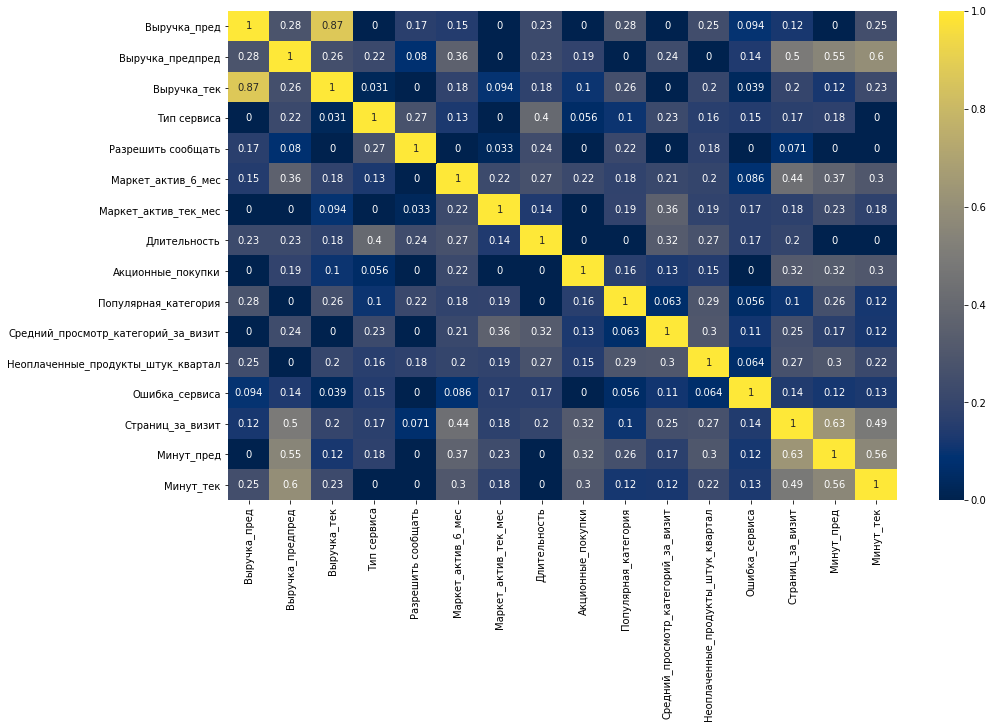

In [76]:
fig, ax = plt.subplots(figsize=(15,9));
sns.heatmap(data_all[data_all['Покупательская активность']=='Снизилась'].drop(columns = ['id', 'Покупательская активность']).phik_matrix(interval_cols = ['Выручка_пред', 'Выручка_предпред', 'Выручка_тек', 'Маркет_актив_6_мес',  'Длительность', 'Акционные_покупки', 'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 'Страниц_за_визит', 'Минут_пред', 'Минут_тек']), annot=True, cmap='cividis', ax = ax);

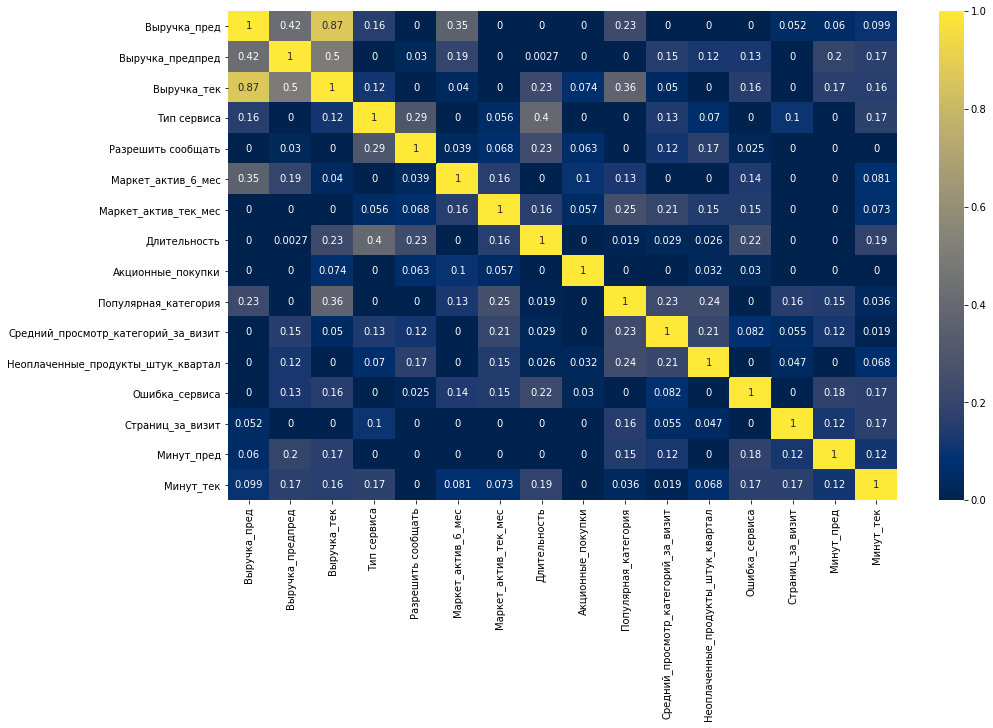

In [77]:
fig, ax = plt.subplots(figsize=(15,9));
sns.heatmap(data_all[data_all['Покупательская активность']=='Прежний уровень'].drop(columns = ['id','Покупательская активность']).phik_matrix(interval_cols = ['Выручка_пред', 'Выручка_предпред', 'Выручка_тек', 'Маркет_актив_6_мес', 'Длительность', 'Акционные_покупки', 'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 'Страниц_за_визит', 'Минут_пред', 'Минут_тек']), annot=True, cmap='cividis', ax = ax);

**Корреляция** довольно сильна между покупательной активностью и количеством просмотренных страниц за визит, также между активностью и количеством проведенных минут на сайте. Также можно наблюдать связь между покупательной активностью и маркетинговой активностью за последние полгода, акционными покупками, просмотром категорий и неоплаченными продуктами.<br>

Что касается взаимосвязи между признаками:<br>
    есть сильная корреляция между выручкой текущей и предыдущей; между временем, проведенным на сайте и количеством просмотренных страниц, что вполне логично.<br>
**Мультиколлинеарность** проявляется между покупательской активностью и id, коэффициент 0,98.<br>
В связи с этим id лучше перенести в индексы таблицы.

## Использование пайплайнов

In [78]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [79]:
data_all['Покупательская активность'].value_counts()

Прежний уровень    802
Снизилась          494
Name: Покупательская активность, dtype: int64

Установим в качестве индексов таблицы id. Этим устраним проблему сильной зависимости покупательской активности от id.

In [80]:
data_all = data_all.set_index('id')

In [81]:
X_train, X_test, y_train, y_test = train_test_split(
    data_all.drop(['Покупательская активность'], axis=1),
    data_all['Покупательская активность'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = data_all['Покупательская активность'])

X_train.shape, X_test.shape

((972, 16), (324, 16))

In [82]:
label_encoder = LabelEncoder()
label_encoder.fit(y_train)

y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test)

In [83]:
print(y_train)

[0 1 0 0 1 0 1 0 0 0 0 1 1 0 0 1 1 1 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0
 0 1 0 1 0 0 0 0 1 0 0 0 0 1 1 0 1 0 1 0 0 0 0 1 0 0 1 0 0 0 1 1 0 1 1 0 1
 0 0 0 0 1 1 0 0 0 1 0 1 0 0 0 1 0 1 0 1 1 0 1 0 1 0 0 0 1 1 1 0 0 0 1 1 1
 0 1 0 0 0 0 1 0 0 1 0 0 1 1 1 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0
 0 1 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 1 1 0 0 1 0 0 1 0 0 0 0 1
 0 1 1 0 0 0 1 1 1 1 1 0 0 0 1 1 0 0 0 0 1 1 1 0 0 1 0 0 0 1 1 0 0 0 0 0 0
 0 1 0 1 0 1 0 0 1 0 1 1 1 0 1 0 1 1 0 1 1 0 1 0 0 0 1 1 0 0 0 1 1 0 0 0 1
 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 1 0 1 1 0 0
 1 1 0 0 0 1 0 0 1 0 1 0 0 1 0 1 1 1 1 0 1 0 1 0 0 0 1 1 0 0 0 1 1 0 0 0 0
 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 1 0 0 0 1 1 0 1 0 0 0 1 1 0 0
 0 0 1 1 1 0 0 1 0 1 0 0 0 1 0 0 0 0 1 0 1 0 0 1 0 0 0 0 1 0 0 1 1 0 0 0 0
 0 1 0 1 1 0 1 0 1 1 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 1
 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 1 0 1 0 0
 0 1 0 1 0 0 1 1 1 1 1 0 

In [84]:
print(label_encoder.inverse_transform(y_train)) 

['Прежний уровень' 'Снизилась' 'Прежний уровень' 'Прежний уровень'
 'Снизилась' 'Прежний уровень' 'Снизилась' 'Прежний уровень'
 'Прежний уровень' 'Прежний уровень' 'Прежний уровень' 'Снизилась'
 'Снизилась' 'Прежний уровень' 'Прежний уровень' 'Снизилась' 'Снизилась'
 'Снизилась' 'Прежний уровень' 'Прежний уровень' 'Прежний уровень'
 'Снизилась' 'Снизилась' 'Снизилась' 'Прежний уровень' 'Прежний уровень'
 'Прежний уровень' 'Прежний уровень' 'Прежний уровень' 'Прежний уровень'
 'Прежний уровень' 'Прежний уровень' 'Снизилась' 'Прежний уровень'
 'Снизилась' 'Прежний уровень' 'Прежний уровень' 'Прежний уровень'
 'Снизилась' 'Прежний уровень' 'Снизилась' 'Прежний уровень'
 'Прежний уровень' 'Прежний уровень' 'Прежний уровень' 'Снизилась'
 'Прежний уровень' 'Прежний уровень' 'Прежний уровень' 'Прежний уровень'
 'Снизилась' 'Снизилась' 'Прежний уровень' 'Снизилась' 'Прежний уровень'
 'Снизилась' 'Прежний уровень' 'Прежний уровень' 'Прежний уровень'
 'Прежний уровень' 'Снизилась' 'Прежний уров

0 означает прежний уровень, 1 снизилась.

In [85]:
print(label_encoder.classes_)

['Прежний уровень' 'Снизилась']


In [86]:
data_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 215349 to 216647
Data columns (total 17 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Выручка_пред                         1296 non-null   float64
 1   Выручка_предпред                     1296 non-null   float64
 2   Выручка_тек                          1296 non-null   float64
 3   Покупательская активность            1296 non-null   object 
 4   Тип сервиса                          1296 non-null   object 
 5   Разрешить сообщать                   1296 non-null   object 
 6   Маркет_актив_6_мес                   1296 non-null   float64
 7   Маркет_актив_тек_мес                 1296 non-null   int64  
 8   Длительность                         1296 non-null   int64  
 9   Акционные_покупки                    1296 non-null   float64
 10  Популярная_категория                 1296 non-null   object 
 11  Средний_просмотр_катего

In [87]:
data_all.head()

,Выручка_пред,Выручка_предпред,Выручка_тек,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Минут_пред,Минут_тек
id,,,,,,,,,,,,,,,,,
215349,5216.0,4472.0,4971.6,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,12,10
215350,5457.5,4826.0,5058.4,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,8,13
215351,6158.0,4793.0,6610.4,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,11,13
215352,5807.5,4594.0,5872.5,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,8,11
215353,4738.5,5124.0,5388.5,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,10,10


In [88]:
# создаём списки с названиями признаков
ohe_columns = ['Тип сервиса', 'Разрешить сообщать', 'Популярная_категория']
#ord_columns = ['Популярная_категория']
num_columns = ['Выручка_пред', 'Выручка_предпред', 'Выручка_тек', 'Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки', 'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 'Страниц_за_визит', 'Минут_пред', 'Минут_тек']

In [89]:
# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False))#drop='first',
    ]
    )

# создаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
# SimpleImputer + OE
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)


Качество оцениваем метрикой ROC_AUC, можно оценивать и метрикой Recall, т.к. важно не пропустить, что активность снизилась.<br>
<br>
ROC_AUC выбрали, т.к.:<br>
    - она учитывает работу модели при всех возможных значениях порогов<br>
    - объектов с одним значением целевого признака больше, чем с другими.

In [90]:
# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     #('ord', ord_pipe, ord_columns),
     ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,5),
        'models__max_features': range(2,5),
        'min_samples_leaf': range(1,10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1,10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели SVC()
    {
        'models': [SVC(
            random_state=RANDOM_STATE, probability= True
        )],
        'models__kernel': ['rbf', 'sigmoid', 'poly'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

# проверьте работу модели на тестовой выборке
# рассчитайте прогноз на тестовых данных
pred = randomized_search.predict_proba(X_test)
pred_one = pred[:,1]
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, pred_one)}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['Тип сервиса',
                                                   'Разрешить сообщать',
                                                   'Популярная_категория']),
                                                 ('num', StandardScaler(),
                                                  [

In [91]:
pd.set_option('display.max_colwidth', None)
result = pd.DataFrame(randomized_search.cv_results_)
display(result[
    ['rank_test_score', 'param_models', 'mean_test_score','params']
].sort_values('rank_test_score'));


,rank_test_score,param_models,mean_test_score,params
8,1,"LogisticRegression(C=4, penalty='l1', random_state=42, solver='liblinear')",0.896370,"{'preprocessor__num': StandardScaler(), 'models__C': 4, 'models': LogisticRegression(C=4, penalty='l1', random_state=42, solver='liblinear')}"
5,2,"SVC(probability=True, random_state=42)",0.885916,"{'preprocessor__num': MinMaxScaler(), 'models__kernel': 'poly', 'models': SVC(probability=True, random_state=42)}"
2,3,KNeighborsClassifier(),0.875236,"{'preprocessor__num': StandardScaler(), 'models__n_neighbors': 3, 'models': KNeighborsClassifier()}"
6,4,KNeighborsClassifier(),0.865970,"{'preprocessor__num': StandardScaler(), 'models__n_neighbors': 2, 'models': KNeighborsClassifier()}"
4,5,KNeighborsClassifier(),0.853780,"{'preprocessor__num': MinMaxScaler(), 'models__n_neighbors': 4, 'models': KNeighborsClassifier()}"
7,6,KNeighborsClassifier(),0.844430,"{'preprocessor__num': MinMaxScaler(), 'models__n_neighbors': 3, 'models': KNeighborsClassifier()}"
3,7,DecisionTreeClassifier(random_state=42),0.793884,"{'preprocessor__num': MinMaxScaler(), 'models__max_features': 3, 'models__max_depth': 3, 'models': DecisionTreeClassifier(random_state=42)}"
9,7,DecisionTreeClassifier(random_state=42),0.793884,"{'preprocessor__num': StandardScaler(), 'models__max_features': 3, 'models__max_depth': 3, 'models': DecisionTreeClassifier(random_state=42)}"
1,9,DecisionTreeClassifier(random_state=42),0.753632,"{'preprocessor__num': 'passthrough', 'models__max_features': 3, 'models__max_depth': 2, 'models': DecisionTreeClassifier(random_state=42)}"
0,10,DecisionTreeClassifier(random_state=42),0.700444,"{'preprocessor__num': StandardScaler(), 'models__max_features': 2, 'models__max_depth': 2, 'models': DecisionTreeClassifier(random_state=42)}"


К данным применили методы масштабирования(StandardScaler(), MinMaxScaler()) и кодирования(OneHotEncoder).<br>
Применяли модели:<br>
    - KNeighborsClassifier с параметром n_neighbors<br>
    - DecisionTreeClassifier с параметрами max_depth, max_features<br>
    - LogisticRegression с параметром C<br>
    - SVC с параметром kernel<br>
Использовали RandomizedSearchCV для подбора гиперпараметров моделей.<br>
<br>
Качество оценивали метрикой ROC_AUC, можно оценивать и метрикой Recall, т.к. важно не пропустить, что активность снизилась.<br>
<br>
ROC_AUC выбрали, т.к.:<br>
    - она учитывает работу модели при всех возможных значениях порогов<br>
    - объектов с одним значением целевого признака больше, чем с другими.

Наилучшей оказалась модель **логистической регрессии** с параметром C, равным 4 и методом масштабирования StandardScaler().

## Анализ важности признаков

In [92]:
feature_names = randomized_search.best_estimator_.named_steps['preprocessor'].transformers_[0][1].named_steps['ohe'].get_feature_names().tolist()+num_columns

In [93]:
print(feature_names)

['x0_премиум', 'x0_стандарт', 'x1_да', 'x1_нет', 'x2_Домашний текстиль', 'x2_Косметика и аксесуары', 'x2_Кухонная посуда', 'x2_Мелкая бытовая техника и электроника', 'x2_Техника для красоты и здоровья', 'x2_Товары для детей', 'Выручка_пред', 'Выручка_предпред', 'Выручка_тек', 'Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки', 'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 'Страниц_за_визит', 'Минут_пред', 'Минут_тек']


In [94]:
data_preprocessor.fit(X_train, y_train)
X_train_p = pd.DataFrame(data_preprocessor.transform(X_train), columns = feature_names)
# выводим предсказанные значения тренировочной выборки
X_test_p = pd.DataFrame(data_preprocessor.transform(X_test), columns = feature_names)

In [95]:
randomized_search.best_estimator_.named_steps['models'].fit(X_train_p, y_train)

LogisticRegression(C=4, penalty='l1', random_state=42, solver='liblinear')

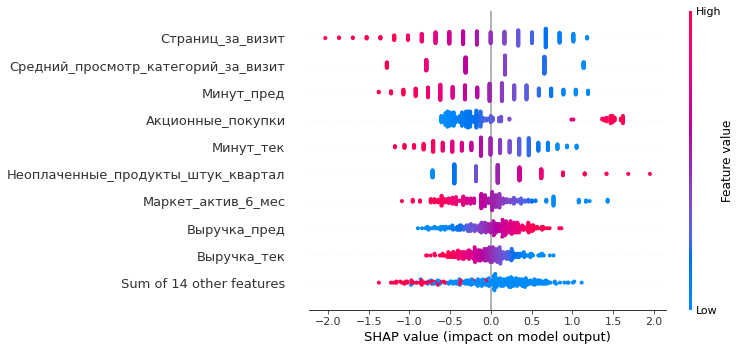

In [96]:
explainer = shap.LinearExplainer(randomized_search.best_estimator_.named_steps['models'], X_test_p)
shap_values = explainer(X_test_p)

shap.plots.beeswarm(shap_values) 

построили график по значениям Шепли.<br>
Интерпретировать его можно следующим образом:
- чем больше просмотрено страниц за визит, тем больше вероятность отнести к классу 0, т.е. прежнему уровню покупательской активности.
- чем больше средний просмотр категорий за визит, тем больше вероятность принадлежности к классу 0.
- чем меньше доля акционных покупок, тем больше вероятность принадлежности к классу 0.

Оценим вклад признаков модели по коэффициентам значимости модели.

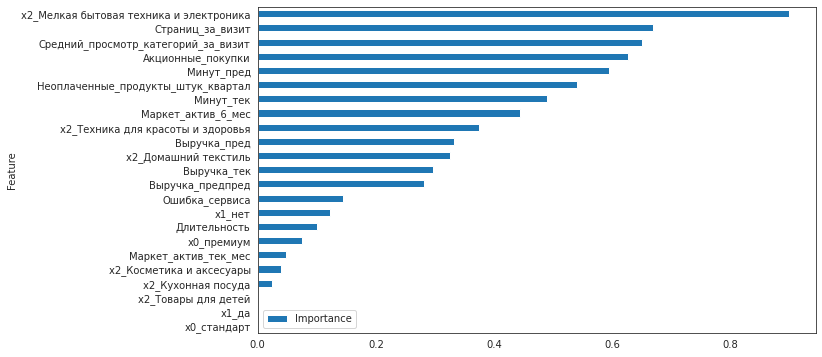

In [97]:
coefficients =randomized_search.best_estimator_.named_steps['models'].coef_[0]
feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance',ascending=True)
sns.set_style('white')
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6));

Самыми значимыми признаками оказались:
- x2_Мелкая бытовая техника и электроника
- Страниц за визит
- Средний просмотр категорий за визит
- Акционные покупки
- Минут_пред

## Сегментация покупателей

In [100]:
X_test['pred'] = pred[:,1]

In [101]:
X_test['y']=y_test

Добавили в данные столбец pred - вероятность снижения покупательской активности, полученную по результату моделирования.

Добавим в данные столбец с Прибылью клиентов из датасета money.

In [102]:
X_test = X_test.merge(money, on='id')

In [103]:
X_test.head()

,id,Выручка_пред,Выручка_предпред,Выручка_тек,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Минут_пред,Минут_тек,pred,y,Прибыль
0,216161,3973.0,4912.0,3289.2,стандарт,да,4.1,4,606,0.15,Техника для красоты и здоровья,6,1,4,12,16,17,0.012997,0,4.69
1,215654,3548.0,4656.0,4170.7,премиум,нет,1.4,4,684,0.94,Товары для детей,3,6,1,6,11,9,0.988981,1,2.75
2,216307,5444.0,4565.0,6335.8,премиум,да,3.3,4,488,0.13,Домашний текстиль,4,2,8,10,20,11,0.103032,0,3.16
3,215501,6604.0,4993.0,6758.7,премиум,да,3.5,3,1057,0.35,Домашний текстиль,4,3,5,6,9,9,0.829093,1,3.74
4,215934,5090.0,4451.0,5773.8,стандарт,нет,5.5,4,147,0.99,Мелкая бытовая техника и электроника,1,2,3,7,15,18,0.505816,1,4.40


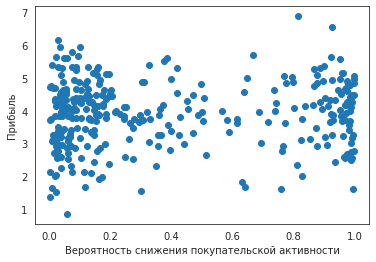

In [120]:
plt.scatter(x=X_test['pred'], y=X_test['Прибыль'])
plt.xlabel('Вероятность снижения покупательской активности')
plt.ylabel('Прибыль');


In [105]:
money.describe()

,id,Прибыль
count,1300.000000,1300.000000
mean,215997.500000,3.996631
std,375.421985,1.013722
min,215348.000000,0.860000
25%,215672.750000,3.300000
50%,215997.500000,4.045000
75%,216322.250000,4.670000
max,216647.000000,7.430000


Отобразили на графике вероятность снижения покупательской активности и Прибыль от клиентов.<br>
Выделим сегмент покупателей, у которых высока вероятность снижения покупательской активности и Прибыль от них высока.<br>
Данный сегмент важно не упустить магазину, т.к. он находится в зоне риска. Магазин может понести убытки, потеряв прибыль от важных клиентов.

По графику выберем верхний правый сегмент: верорятность снижения активности >0.6 и прибыль больше медианной. Порог выбрали по графику: он больше 0.5 и с этого значения снова увеличивается количество наблюдений и количество клиентов с высокой прибылью.

In [109]:
X_test_part = X_test[(X_test['Прибыль']>4.04)&(X_test['pred']>0.6)]

In [110]:
X_test_part['id'].count()

54

Выделили сегмент покупателей. Всего 54 покупателя.

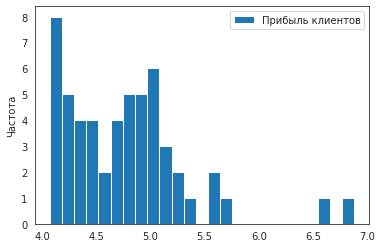

In [115]:
plt.hist(X_test_part['Прибыль'], bins=25,  label = 'Прибыль клиентов')
plt.legend(loc='upper right')
plt.ylabel("Частота");
plt.show()

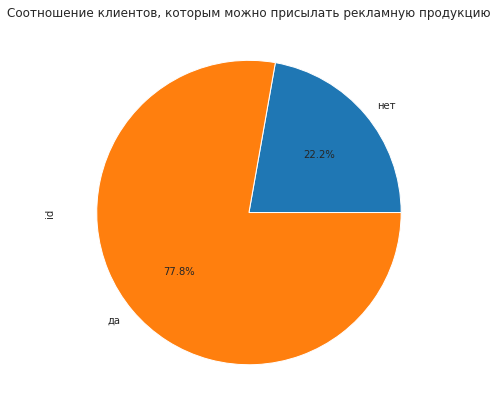

In [112]:
X_test_part.pivot_table(index = 'Разрешить сообщать', aggfunc = 'count')['id'].sort_values().plot(title='Соотношение клиентов, которым можно присылать рекламную продукцию', kind='pie', figsize = (10,7),  autopct='%1.1f%%', legend = False);


Большинству клиентов из данного сегмента можно присылать рекламную продукцию.

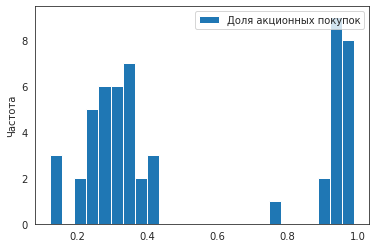

In [122]:
plt.hist(x = X_test_part['Акционные_покупки'], bins = 25,  label = 'Доля акционных покупок');
plt.legend(loc='upper right')
plt.ylabel("Частота");
plt.show()

Среди клиентов из данного сегмента доля акционных покупок довольно сильно различается, не видно сильной взаимосвязи, но есть некоторые клиенты, у которых доля акционных покупок довольно велика - под 100%. Можно усилить их информирование о текущих акциях.

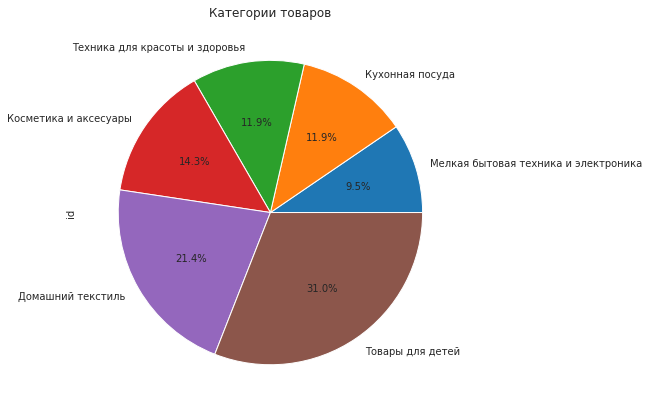

In [125]:
X_test_part.pivot_table(index = 'Популярная_категория', aggfunc = 'count')['id'].sort_values().plot(title='Категории товаров', kind='pie', figsize = (10,7),  autopct='%1.1f%%', legend = False);


Больше всего клиенты из данного сегмента покупают товары из категорий: Товары для детей, Домашний текстиль. Выгодно проводить акции и рекламу по данным видам товаров.

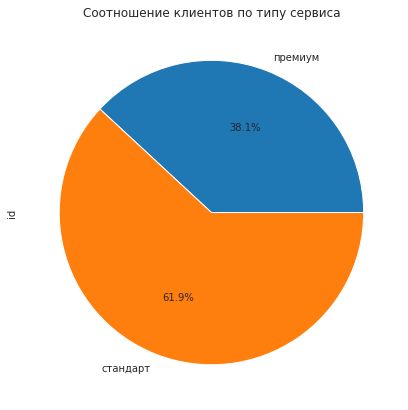

In [127]:
X_test_part.pivot_table(index = 'Тип сервиса', aggfunc = 'count')['id'].sort_values().plot(title='Соотношение клиентов по типу сервиса', kind='pie', figsize = (10,7),  autopct='%1.1f%%', legend = False);


Клиентов с типом сервиса стандарт больше половины: 62%.

Выделим список клиентов, которым можно рассылать предложения.

In [123]:
X_test_part = X_test_part[X_test_part['Разрешить сообщать'] == 'да']

In [124]:
display(X_test_part)

,id,Выручка_пред,Выручка_предпред,Выручка_тек,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Минут_пред,Минут_тек,pred,y,Прибыль
12,215375,5253.5,4715.0,5633.1,премиум,да,3.0,4,558,0.89,Товары для детей,3,3,7,4,8,9,0.971294,1,4.18
18,215452,4045.0,4963.0,4206.2,стандарт,да,3.8,4,756,0.90,Товары для детей,2,3,6,4,11,10,0.955086,1,4.50
38,215496,5020.0,4896.0,5237.1,премиум,да,4.0,4,684,0.40,Техника для красоты и здоровья,1,6,2,4,11,11,0.944979,1,4.64
48,215737,5126.0,4679.0,5291.1,стандарт,да,0.9,4,225,0.36,Косметика и аксесуары,2,4,2,3,9,10,0.985324,1,4.80
52,215390,4254.0,4549.0,4612.8,стандарт,да,3.1,4,152,0.33,Косметика и аксесуары,6,4,2,5,8,12,0.668838,1,5.70
60,215628,3783.0,4566.0,3848.0,стандарт,да,4.0,4,618,0.93,Товары для детей,3,5,2,2,9,10,0.986777,1,4.11
63,215402,4918.0,4702.0,4940.1,премиум,да,3.0,5,954,0.93,Товары для детей,3,2,4,6,5,5,0.988868,1,4.28
66,215351,6158.0,4793.0,6610.4,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,11,13,0.796931,1,4.87
75,215600,6134.0,4646.0,5781.7,стандарт,да,2.4,4,446,0.29,Кухонная посуда,1,6,3,4,13,14,0.968352,1,4.65
95,216565,4844.0,4908.0,5533.0,стандарт,да,5.2,5,638,0.15,Домашний текстиль,1,5,8,4,17,12,0.637227,0,4.58


Выделили сегмент покупателей: Группа клиентов с высокой вероятностью снижения покупательской активности и высокой прибылью.<br>
Из них нашли клиентов, у которых снизилась покупательская активность и отмечено, что можно сообщать дополнительную информацию о товарах.<br>
Таким покупателям можно рассылать предложения по новинкам и выгодным покупкам. <br>
Акционными товарами некоторые из них интересуются, их можно отобрать и присылать текущие акции.
Возможно предоставить покупателям скидку на приобретение товаров из категории Товары для детей, Домашний текстиль - самые популярные категории. Размер сикдки может быть расчитан, исходя из возможной прибыли/убытков. <br>
Для покупателей можно на сайте выводить рекомендуемые к покупке товары или товары, которые могут стать дополнением к уже купленным/покупаемым.

## Вывод

### Общий анализ данных:<br>
Были изучены данные о клиентах интернет-магазина "В один клик".<br>
Данные содержат коммуникации с клиентом, продуктовое и финансовое поведение, поведение на сайте.<br>
Целью исследования было:
- построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.<br>
- выделить сегменты покупателей и разработать для них персонализированные предложения.


### Предобработка данных:
В данных о клиентах магазина не было обнаружено явных дубликатов, неявные дубликаты скорректированы.<br>
Пропусков обнаружено не было.<br>
Всего получилось 1300 строк.


### Исследовательский анализ:
Проанализировали признаки:
- нашли 1 аномальную строку с очень большим значение Выручки, ее удалили.
Необходимо масштабировать количественные признаки и закодировать категориальные для использования их в модели регрессии.
Удалили неактивных клиентов, осталось 1296 строк.

### Объединение таблиц:
Объединили данные из всех таблиц. Приэтом данные по выручке за каждый период распределили по отдельным столбцам.

### Корреляционный анализ:
**Корреляция** довольно сильна между покупательной активностью и количеством просмотренных страниц за визит, также между активностью и количеством проведенных минут на сайте. Также можно наблюдать связь между покупательной активностью и маркетинговой активностью за последние полгода, акционными покупками, просмотром категорий и неоплаченными продуктами.<br>

Что касается взаимосвязи между признаками:<br>
есть сильная корреляция между выручкой текущей и предыдущей; между временем, проведенным на сайте и количеством просмотренных страниц, что вполне логично.<br>
**Мультиколлинеарность** проявляется между покупательской активностью и id, коэффициент 0,98.<br>
В связи с этим id перенесли в индексы таблицы.

### Использование пайплайнов:
Создали пайплайн, который обрабатывает данные и строит модель классификации.
К данным применили методы масштабирования(StandardScaler(), MinMaxScaler()) и кодирования(OneHotEncoder).<br>
Применяли модели:<br>
    - KNeighborsClassifier с параметром n_neighbors<br>
    - DecisionTreeClassifier с параметрами max_depth, max_features<br>
    - LogisticRegression с параметром C<br>
    - SVC с параметром kernel<br>
Использовали RandomizedSearchCV для подбора гиперпараметров моделей.<br>
<br>
Выбрали метрику ROC_AUC, т.к.:<br>
    - она учитывает работу модели при всех возможных значениях порогов<br>
    - объектов с одним значением целевого признака больше, чем с другими.<br>
<br>
Наилучшей оказалась модель **логистической регрессии** с параметром C, равным 4 и методом масштабирования StandardScaler().


### Анализ важности признаков:
построили график по значениям Шепли.<br>
Интерпретировать его можно следующим образом:
- чем больше просмотрено страниц за визит, тем больше вероятность отнести к классу 0, т.е. прежнему уровню покупательской активности.
- чем больше средний просмотр категорий за визит, тем больше вероятность принадлежности к классу 0.
- чем меньше доля акционных покупок, тем больше вероятность принадлежности к классу 0.

Проанализировали коэффициенты модели логистической регрессии.<br>
Самыми значимыми признаками оказались:<br>
- x2_Мелкая бытовая техника и электроника
- Страниц за визит
- Средний просмотр категорий за визит
- Акционные покупки
- Минут_пред

### Сегментация покупателей:
Выделили сегмент покупателей: Группа клиентов с высокой вероятностью снижения покупательской активности и высокой прибылью.<br>
Из них нашли клиентов, у которых снизилась покупательская активность и отмечено, что можно сообщать дополнительную информацию о товарах.<br>
Таким покупателям можно рассылать предложения по новинкам и выгодным покупкам. <br>
Акционными товарами некоторые из них интересуются, их можно отобрать и присылать текущие акции.
Возможно предоставить покупателям скидку на приобретение товаров из категории Товары для детей, Домашний текстиль - самые популярные категории. Размер сикдки может быть расчитан, исходя из возможной прибыли/убытков. <br>
Для покупателей можно на сайте выводить рекомендуемые к покупке товары или товары, которые могут стать дополнением к уже купленным/покупаемым.